In [20]:
import argparse
from math import inf
import os
import numpy as np
import torch
from torch import nn, optim
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.nn import functional as F
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
from env import CONTROL_SUITE_ENVS, Env, GYM_ENVS, EnvBatcher
from memory import ExperienceReplay

from models import bottle, Encoder, ObservationModel, RewardModel, TransitionModel
from plannerCreate import MPCPlanner
# from planner import MPCPlanner
from utils import lineplot, write_video
import sys
sys.path.insert(0, '/home/soham/USC/Courses/CSCI566_DeepLearning/CREATE')
from create_game import register_json_folder, register_json_str
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "html5"
import matplotlib.animation
import gym
import random

Loading chipmunk for Linux (64bit) [/home/soham/USC/Courses/CSCI566_DeepLearning/create/lib/python3.8/site-packages/pymunk/libchipmunk.so]
pygame 2.1.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/soham/USC/Courses/CSCI566_DeepLearning/create/lib/python3.8/site-packages/cffi/cparser.py:163: UserWarning: Global variable '_cpBBNewForExtents' in cdef(): for consistency with C it should have a storage class specifier (usually 'extern')
  warnings.warn("Global variable '%s' in cdef(): for consistency "
/home/soham/USC/Courses/CSCI566_DeepLearning/create/lib/python3.8/site-packages/cffi/cparser.py:163: UserWarning: Global variable '_cpBBNewForCircle' in cdef(): for consistency with C it should have a storage class specifier (usually 'extern')
  warnings.warn("Global variable '%s' in cdef(): for consistency "
/home/soham/USC/Courses/CSCI566_DeepLearning/create/lib/python3.8/site-packages/cffi/cparser.py:163: UserWarning: Global variable '_cpBBIntersects' in cdef(): for consistency with C it should have a storage class specifier (usually 'extern')
  warnings.warn("Global variable '%s' in cdef(): for consistency "
/home/soham/USC/Courses/CSCI566_DeepLearning/create/lib/python3.8/si

In [2]:
register_json_folder('/home/soham/USC/Courses/CSCI566_DeepLearning/CREATE/examples/five_envs')

In [13]:
env1 = Env('CreateLevelTwoCustomPush0-v0',False, 1, 1000, 2, 10)
env2 = Env('CreateLevelTwoCustomPush1-v0',False, 1, 1000, 2, 10)
env3 = Env('CreateLevelTwoCustomPush2-v0',False, 1, 1000, 2, 10)
env4 = Env('CreateLevelTwoCustomPush3-v0',False, 1, 1000, 2, 10)
env5 = Env('CreateLevelTwoCustomPush4-v0',False, 1, 1000, 2, 10)
env_list = [env1,env2,env3,env4,env5]

In [27]:
# register_json_folder('/home/soham/USC/Courses/CSCI566_DeepLearning/CREATE/examples/custom_json')
# json_str = """ {
#     "name": "CustomPush2",
#     "lvl_type": "marker",
#     "target": "[-0.1, -0.25 + OFFSET]",
#     "goal": "[0.7, -0.75 + OFFSET]",
#     "rnd": {
#         "marker_ball:0": "[uniform(-HIGH_NOISE, HIGH_NOISE), uniform(-HIGH_NOISE, HIGH_NOISE)]",
#         "target,medium_floor:0": "[uniform(-HIGH_NOISE, HIGH_NOISE), uniform(-HIGH_NOISE, HIGH_NOISE)]",
#         "goal,medium_floor:1": "[uniform(-HIGH_NOISE, HIGH_NOISE), uniform(-HIGH_NOISE, HIGH_NOISE)]"
#     },  
#     "env": [
#         {   
#             "name": "marker_ball",
#             "pos": [0.6, 0.75],
#             "id": 0
#         },  
#         {   
#             "name": "medium_floor",
#             "pos": "[0.1, -0.25]",
#             "id": 0
#         },  
#         {   
#             "name": "medium_floor",
#             "pos": "[0.7, -0.75]",
#             "id": 1
#         }   
#     ]   
# }
# """
# tools_list = [0,2,10,15,21,25,35,150,600]
tools_list = [0,2,15,25]
# solver_x_y = [[0.7,0.5],[-0.35,-0.5]]
# # solver_tools = [0,10,15,21,600]
# solver_tools = [0,15]
env1_solver_xy = [[0.6,0.5],[-0.35,-0.5]]
env1_solver_tools = [[0,15],[0,15]]
env2_solver_xy = [[0.7,0.5],[-0.2,-0.5]]
env2_solver_tools = [[15],[0,15]]
env3_solver_xy = [[0.6,0.3],[-0.4,-0.65]]
env3_solver_tools = [[0,15],[0]]
env4_solver_xy = [[0.55,0.3],[-0.4,-0.5]]
env4_solver_tools = [[0,15],[15]]
env5_solver_xy = [[0.6,0.3],[-0.3,-0.5]]
env5_solver_tools = [[15],[0,15]]

env_solver_xy = [env1_solver_xy,env2_solver_xy,env3_solver_xy,env4_solver_xy,env5_solver_xy]
env_solver_tools = [env1_solver_tools,env2_solver_tools,env3_solver_tools,env4_solver_tools,env5_solver_tools]

def generate_actions(solve,solver_xy,solver_tools):  
    actions = []
    for i in range(9):
        tool = tools_list[random.randint(0,len(tools_list)-1)]
        done = False
        while not done:
            x = random.uniform(-1,1)
            y = random.uniform(-1,1)
            if not (solve and (0 > x > -0.65 and -0.2 > y > -0.8) and (0.9 > x > 0 and 0.8 > y > 0)):
                done = True
            actions.append([tool,x,y])
    if solve:
        actions[0] = [solver_tools[0][random.randint(0,len(solver_tools[0])-1)],solver_xy[0][0],solver_xy[0][1]]
        actions[4] = [solver_tools[1][random.randint(0,len(solver_tools[1])-1)],solver_xy[1][0],solver_xy[1][1]]
    return actions

In [28]:
not_solved_counter = 0
attempts_to_solve = 0

In [30]:
D = ExperienceReplay(100000, False, env1.observation_size, env1.action_size, 5, torch.device('cuda'))
# Initialise dataset D with S random seed episodes
for s in range(1, 50000 + 1):
  env_num = random.randint(1,5)
  env = env_list[env_num-1]
  observation, done, t = env.reset(), False, 0
  solve = True if random.random() > 0.5 else False
  if solve:
    attempts_to_solve += 1
  actions = generate_actions(solve,env_solver_xy[env_num-1],env_solver_tools[env_num-1])
  solved = False
  while not done:
    # action = env.sample_random_action()
    action = torch.tensor(actions[t%len(actions)])
    # action[...,:1] = torch.FloatTensor([0]) if random.random()>0.5 else torch.FloatTensor([15])
    next_observation, reward, done = env.step(action)
    if solve and reward > 5:
      solved = True
    D.append(observation, action, reward, done)
    observation = next_observation
    t += 1
  if solve == True and solved == False:
    not_solved_counter +=1
  # metrics['steps'].append(t * args.action_repeat + (0 if len(metrics['steps']) == 0 else metrics['steps'][-1]))
  # metrics['episodes'].append(s)

In [33]:
torch.save(D,"Replay_50000_4_tools_5_envs.pth")

In [34]:
for env in env_list:
    env.close()

In [9]:
D = torch.load("example_save.pth")

In [12]:
D.observations.shape

(10000, 1, 64, 64)

In [1]:
train_rewards = [0.01,0.01,0.02,0.01,0.01,0.03,0.01,0.03,0.03,0.02,0.02,0.02,0.03,0.01,0.01,0.02,0.02,0.02,0.02,0.01,0.02,0.03,0.02,0.02,0.03,0.02,0.04,0.02,0.060000000000000005,0.03,0.02,0.03,9.649999999999999,0.04,0.04,0.02,0.04,0.03,0.03,0.03,0.04,0.07,0.03,0.04,0.03,0.02,0.060000000000000005,0.060000000000000005,0.04,0.04,0.07,0.060000000000000005,0.060000000000000005,0.03,0.04,0.05,0.02,0.05,0.07,0.04,0.03,0.03,0.05,0.04,0.04,0.04,0.04,0.04,0.05,0.05,0.03,0.03,0.060000000000000005,0.05,9.46,0.04,0.02,0.03,0.01,0.03,0.05,0.060000000000000005,0.08,9.57,0.05,0.02,0.03,0.10999999999999999,0.04,0.02,0.04,0.07,0.060000000000000005,0.07,9.549999999999999,0.03,0.07,0.03,0.01,9.55,0.03,0.03,0.03,0.04,0.02,0.02,0.060000000000000005,0.03,0.02,0.02,0.07,0.05,0.03,0.01,0.02,0.02,9.46,0.060000000000000005,9.649999999999999,0.03,0.04,0.04,0.03,0.03,0.04,0.04,0.04,0.08,0.03,0.05,0.03,0.060000000000000005,0.03,0.03,0.060000000000000005,0.04,0.07,0.07,0.03,0.03,0.03,0.060000000000000005,0.07,9.46,0.03,0.07,0.07,0.03,9.46,0.07,0.02,0.04,0.060000000000000005,0.09999999999999999,0.060000000000000005,0.03,0.07,0.03,0.05,0.07,0.05,0.01,0.05,0.02,0.03,0.03,0.04,9.659999999999998,9.55,9.46,0.03,0.060000000000000005,0.05,0.03,0.04,0.02,0.060000000000000005,9.46,0.060000000000000005,0.02,0.04,0.02,0.03,0.060000000000000005,0.03,9.659999999999998,0.08,0.03,0.03,0.05,0.04,0.08,0.060000000000000005,0.09,0.060000000000000005,0.02,0.05,0.02,9.28,0.03,9.559999999999999,0.060000000000000005,0.03,0.03,0.01,0.03,9.559999999999999,0.060000000000000005,0.01,0.04,0.04,0.060000000000000005,0.04,0.03,0.02,0.060000000000000005,0.02,0.02,0.04,0.02,0.04,0.04,0.03,0.04,0.04,0.07,0.03,0.03,0.04,0.04,0.04,0.04,9.739999999999998,0.04,0.060000000000000005,0.02,0.02,0.04,0.02,0.060000000000000005,0.03,0.01,0.04,0.05,0.02,0.05,0.04,0.04,0.04,9.48,0.01,0.02,9.56,0.04,0.04,0.02,0.04,0.03,0.02,0.03,0.02,0.060000000000000005,0.02,0.05,0.02,9.370000000000001,0.03,0.05,0.03,0.02,0.02,0.060000000000000005,0.02,0.03,0.08,0.01,0.04,0.05,0.060000000000000005,0.060000000000000005,0.09999999999999999,0.02,0.08,0.03,0.05,0.03,0.03,0.08,0.08,0.04,0.03,0.02,0.02,0.03,0.03,0.02,0.02,0.04,0.04,0.02,0.060000000000000005,0.04,0.02,0.02,0.02,0.02,0.04,0.02,0.08,0.02,0.03,0.03,0.05,0.060000000000000005]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


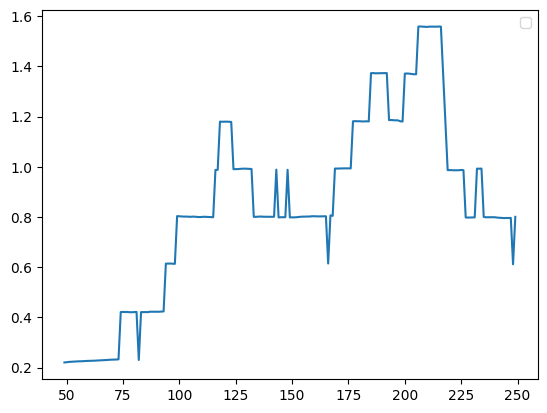

In [9]:
import pandas as pd
import matplotlib.pyplot as plt


# create a pandas series from the list
series = pd.Series(train_rewards[:250])

# calculate the rolling mean with a window of 10
rolling_mean = series.rolling(window=50).mean()

# plot the original series and the rolling mean
# plt.plot(series.index, series, label='Original')
plt.plot(rolling_mean.index, rolling_mean)
plt.legend()
plt.show()

In [16]:
test_rewards = [0.01899999938905239,0.03599999472498894,0.025999996811151505,1.0069999694824219,1.94100022315979,1.032999999821186066,2.036000002175569534,5.719000339508057,4.785000324249268,1.9209998846054077,0.03099999763071537,0.04700000211596489]

In [13]:
max(test_rewards)

0.04999999701976776

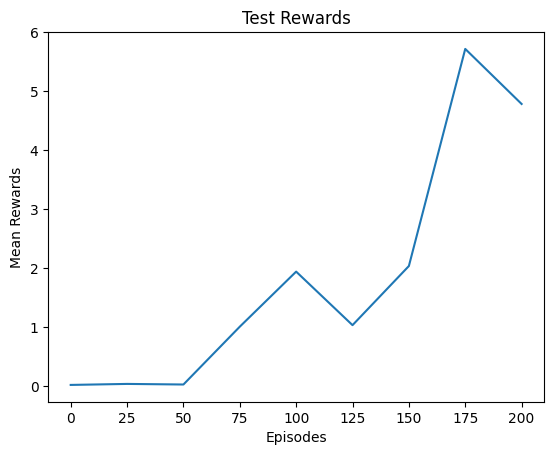

In [23]:
# create a pandas series from the list
series = pd.Series(test_rewards[:9])

# calculate the rolling mean with a window of 10
rolling_mean = series.rolling(window=1).mean()

# plot the original series and the rolling mean
# plt.plot(series.index, series, label='Original')
plt.plot(25*np.arange(len(rolling_mean)), rolling_mean)
plt.xlabel("Episodes")
plt.ylabel("Mean Rewards")
plt.title("Test Rewards")
# plt.legend()
plt.show()

In [24]:
reward_model_loss = [3.3890740871429443,3.2788808345794678,1.2822129726409912,0.4693757891654968,0.3914242088794708,0.32492396235466003,0.2563544511795044,0.23185600340366364,0.21102912724018097,0.2047061026096344,0.1835426390171051,0.17271111905574799,0.17729723453521729,0.17164374887943268,0.1607877016067505,0.1537289172410965,0.15397262573242188,0.15850228071212769,0.1545594483613968,0.15059316158294678,0.13111916184425354,0.14731699228286743,0.14160531759262085,0.13625776767730713,0.13053908944129944,0.12253150343894958,0.12767332792282104,0.1209859624505043,0.11152318865060806,0.11422926932573318,0.11116892844438553,0.11842173337936401,0.10217509418725967,0.09710775315761566,0.09930385649204254,0.08619377017021179,0.08500561863183975,0.08494219183921814,0.08798936009407043,0.08546679466962814,0.08907325565814972,0.08197048306465149,0.08102516829967499,0.08733341097831726,0.0828334391117096,0.07476277649402618,0.08200457692146301,0.08160341531038284,0.07070206105709076,0.07065079361200333,0.06265735626220703,0.0724826529622078,0.06943851709365845,0.06562461704015732,0.06760325282812119,0.06685299426317215,0.07070090621709824,0.06126943603157997,0.05830392241477966,0.060544662177562714,0.054016780108213425,0.057681355625391006,0.04871201887726784,0.05348842218518257,0.05110236257314682,0.05440787225961685,0.05303015559911728,0.0539453849196434,0.0567946583032608,0.051626287400722504,0.050525251775979996,0.05530409887433052,0.05231732875108719,0.04777466878294945,0.04806923866271973,0.046134356409311295,0.05080528184771538,0.052120309323072433,0.048630788922309875,0.04987001791596413,0.0468849278986454,0.09209823608398438,0.047827571630477905,0.04316657409071922,0.043883875012397766,0.04273966699838638,0.04094981029629707,0.03976438194513321,0.040959782898426056,0.03703752160072327,0.043204132467508316,0.04257313162088394,0.0436013899743557,0.046708229929208755,0.04583171010017395,0.04175320640206337,0.043221306055784225,0.03943370655179024,0.03485073894262314,0.03778746724128723,0.03316905349493027,0.04173438996076584,0.04021690413355827,0.03550254926085472,0.036870721727609634,0.03317524492740631,0.03721798583865166,0.03613481670618057,0.034492749720811844,0.03475199267268181,0.03227522224187851,0.03863837569952011,0.03196365386247635,0.036624740809202194,0.030256541445851326,0.031971368938684464,0.033275581896305084,0.035127583891153336,0.03846406191587448,0.037613991647958755,0.029544347897171974,0.035050686448812485,0.03540928289294243,0.03015165962278843,0.02976897917687893,0.026471851393580437,0.031235678121447563,0.036078501492738724,0.026065625250339508,0.03316320478916168,0.030484916642308235,0.033823274075984955,0.02559799514710903,0.029439082369208336,0.030554398894309998,0.029806630685925484,0.02886081486940384,0.029328718781471252,0.025839244946837425,0.022390073165297508,0.026174001395702362,0.032226644456386566,0.032070960849523544,0.03936224430799484,0.030877433717250824,0.026242850348353386,0.029968544840812683,0.03203301504254341,0.02546193078160286,0.025639072060585022,0.021128883585333824,0.029587822034955025,0.027889328077435493,0.026573078706860542,0.029338929802179337,0.023101510480046272,0.026267366483807564,0.02490289881825447,0.02635512314736843,0.024595150724053383,0.023079946637153625,0.02513170801103115,0.02796567976474762,0.024162249639630318]

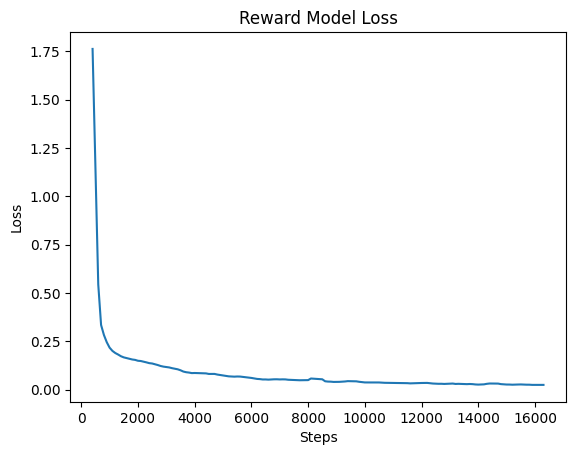

In [29]:
series = pd.Series(reward_model_loss)

# calculate the rolling mean with a window of 10
rolling_mean = series.rolling(window=5).mean()

# plot the original series and the rolling mean
# plt.plot(series.index, series, label='Original')
plt.plot(100*np.arange(len(rolling_mean)), rolling_mean)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Reward Model Loss")
# plt.legend()
plt.show()

In [31]:
observation_loss = [246.48365783691406,148.14053344726562,137.1099395751953,96.37053680419922,81.59149169921875,76.07454681396484,73.2384262084961,71.3079605102539,69.53457641601562,68.44359588623047,67.64323425292969,66.01129150390625,65.05233764648438,64.1235122680664,62.866004943847656,61.111976623535156,59.834754943847656,58.13728332519531,56.5332145690918,55.2792854309082,53.94369125366211,52.78639221191406,51.825286865234375,50.60776901245117,50.1748046875,49.245784759521484,48.36943054199219,47.722991943359375,46.81973648071289,46.950626373291016,45.979164123535156,45.260562896728516,44.899658203125,44.2092399597168,43.94644546508789,43.697139739990234,42.968994140625,42.682891845703125,42.55873489379883,42.291629791259766,41.69154357910156,41.49186706542969,41.1728515625,40.766258239746094,40.710487365722656,40.1843376159668,39.89833068847656,39.76646423339844,39.413631439208984,39.486610412597656,39.021148681640625,38.727237701416016,38.544960021972656,38.119117736816406,38.241172790527344,37.813438415527344,37.57144546508789,37.45330047607422,37.158966064453125,37.06981658935547,37.11093521118164,36.67264938354492,36.66240310668945,36.486724853515625,36.53187561035156,36.14608383178711,36.05299758911133,35.97822189331055,35.736385345458984,35.70781707763672,35.52436828613281,35.32353210449219,35.2574462890625,34.92988586425781,35.125587463378906,34.88764953613281,34.74506759643555,34.5262565612793,34.3225212097168,34.55424880981445,34.130950927734375,36.734893798828125,34.55223083496094,33.9295768737793,33.86748504638672,33.88148498535156,33.4172477722168,33.51060485839844,33.51084518432617,33.539642333984375,33.274269104003906,33.24306869506836,33.25248718261719,33.060218811035156,33.033939361572266,32.84262466430664,32.75215148925781,32.75475311279297,32.43117904663086,32.63834762573242,32.52983474731445,32.3502197265625,32.27641296386719,32.12504577636719,32.33943557739258,31.944990158081055,31.886682510375977,31.96172332763672,31.733854293823242,31.759321212768555,31.913009643554688,31.828004837036133,31.560514450073242,31.608142852783203,31.66307830810547,31.404273986816406,31.403932571411133,31.382062911987305,31.235462188720703,31.235010147094727,31.05890655517578,31.046335220336914,30.999723434448242,30.815046310424805,31.02871322631836,30.861509323120117,30.722240447998047,30.646059036254883,30.553874969482422,30.709583282470703,30.41058349609375,30.297948837280273,30.458690643310547,30.228845596313477,30.21892738342285,30.486431121826172,30.022310256958008,30.063282012939453,30.187294006347656,30.229887008666992,29.941869735717773,30.000652313232422,30.012338638305664,30.234600067138672,29.906028747558594,29.692848205566406,29.684785842895508,29.642412185668945,29.463516235351562,29.681791305541992,29.536252975463867,29.390871047973633,29.35095977783203,29.235769271850586,29.395893096923828,29.105125427246094,29.079145431518555,29.153196334838867,28.933244705200195,28.920705795288086,29.090866088867188,28.845897674560547,28.85293197631836,28.862028121948242,28.948631286621094,28.778230667114258,28.769296646118164,28.754392623901367,28.55622100830078,28.62533950805664,28.446470260620117,28.413480758666992,28.4964599609375,28.2143611907959,28.470788955688477,28.325857162475586,28.224071502685547,28.155868530273438,27.985013961791992,28.51715087890625,27.928936004638672,27.84344482421875]
observation_loss = observation_loss[:len(reward_model_loss)]

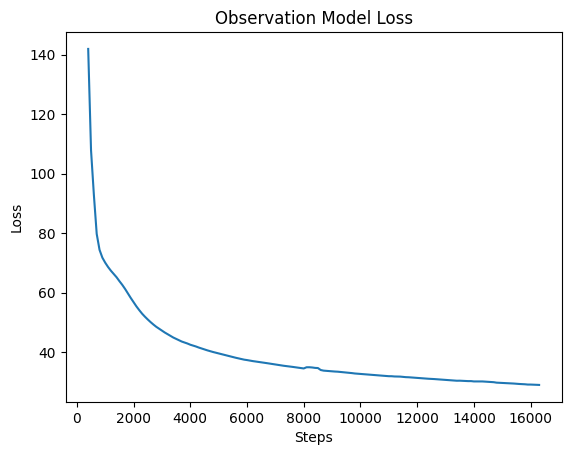

In [32]:
series = pd.Series(observation_loss)

# calculate the rolling mean with a window of 10
rolling_mean = series.rolling(window=5).mean()

# plot the original series and the rolling mean
# plt.plot(series.index, series, label='Original')
plt.plot(100*np.arange(len(rolling_mean)), rolling_mean)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Transition Model Loss")
# plt.legend()
plt.show()